# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

### Archivo Drive con presentación en PDF: https://drive.google.com/drive/folders/1YocBF1BepjnL3_MUuw5xf-7N-9LakURV

## 1. Carga y preparación de datos

In [1]:
# Importamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Cargamos nuestros datasets
telecom = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients = pd.read_csv('/datasets/telecom_clients_us.csv')

In [3]:
# Revisamos qué contienen nuestros datasets
telecom.info()
telecom.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


(53902, 9)

In [4]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [5]:
telecom.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [6]:
clients.info()
clients.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


(732, 3)

In [7]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [8]:
clients.describe()

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


In [9]:
# Convertimos las fechas a formato datetime
telecom['date'] = pd.to_datetime(telecom['date'])

clients['date_start'] = pd.to_datetime(clients['date_start'])

In [10]:
# Eliminamos valores nulos de nuestra base telecom
telecom = telecom.dropna(subset=['operator_id'])

In [11]:
# Eliminamos operadores sin ID
telecom['operator_id'] = telecom['operator_id'].astype(int)

Eliminamos los registros de operadores sin ID de nuestra columna operator_id, ya que no pueden atribuirse a un operador específico. Dado que el objetivo del estudio es evaluar la eficiencia individual de los operadores, incluir estos registros ausentes introduciría ruido y distorsionaría las métricas agregadas.

## 2. Análisis Exploratorio de Datos

In [12]:
# Queremos saber cómo se distribuyen las llamadas
telecom['direction'].value_counts(normalize=True)

out    0.693571
in     0.306429
Name: direction, dtype: float64

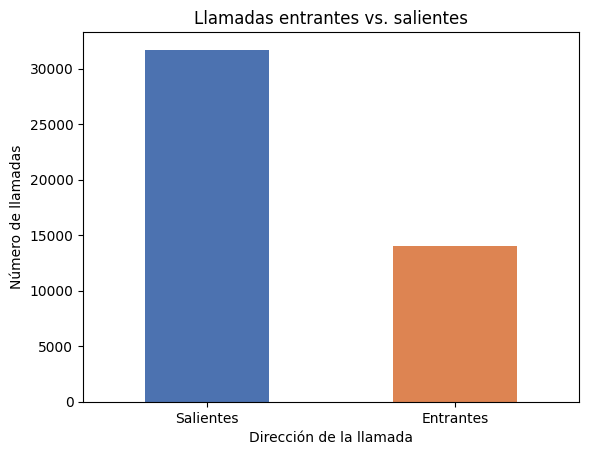

In [13]:
telecom['direction'].value_counts().plot(kind='bar', color=['#4C72B0', '#DD8452'])
plt.title('Llamadas entrantes vs. salientes')
plt.xlabel('Dirección de la llamada')
plt.ylabel('Número de llamadas')
plt.xticks([0, 1], ['Salientes', 'Entrantes'],rotation=0)
plt.show()

Revisando la proporción de llamadas, nos damos cuenta que hay un mayor número de llamadas salientes que entrantes (más del doble).

In [14]:
# Ahora, quetemos saber cuántas llamadas perdidas hay
telecom['is_missed_call'].value_counts(normalize=True)

False    0.66066
True     0.33934
Name: is_missed_call, dtype: float64

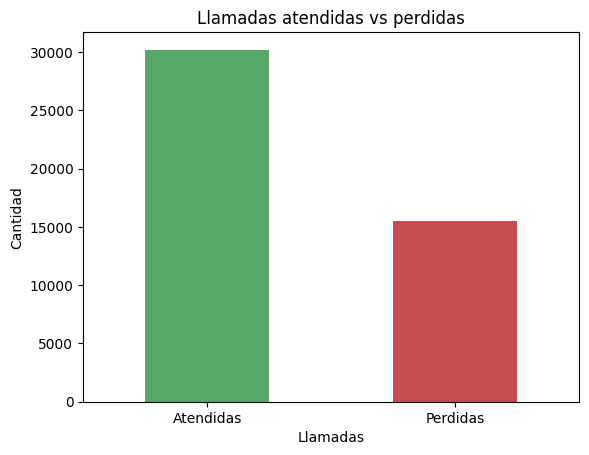

In [15]:
telecom['is_missed_call'].value_counts().plot(kind='bar', color=['#55A868', '#C44E52'])
plt.title('Llamadas atendidas vs perdidas')
plt.xlabel('Llamadas')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['Atendidas', 'Perdidas'], rotation=0)
plt.show()

En cuanto al número de llamadas atendidas y perdidas, el mayor número se centra en las atendidas. Sin embargo, vemos que casi la mitad de las llamadas son perdidas, lo que implica que es un gran volumen para el total.

## 3. Definición de métricas de ineficacia

In [16]:
# La primera métrica que queremos saber es el tiempo de espera de las llamadas
telecom['waiting_time'] = telecom['total_call_duration'] - telecom['call_duration']
telecom['waiting_time'].describe()

count    45730.000000
mean       312.376667
std       1174.185593
min          0.000000
25%         19.000000
50%         60.000000
75%        220.000000
max      46474.000000
Name: waiting_time, dtype: float64

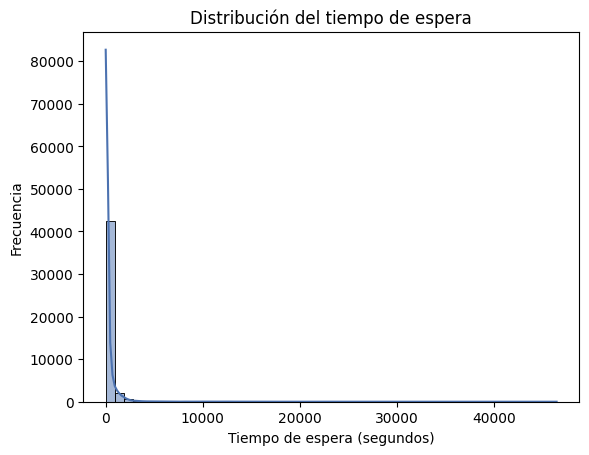

In [17]:
sns.histplot(telecom['waiting_time'], bins=50, kde=True, color='#4C72B0')
plt.title('Distribución del tiempo de espera')
plt.xlabel('Tiempo de espera (segundos)')
plt.ylabel('Frecuencia')
plt.show()

Viendo la distribución del tiempo de espera, nos damos cuenta que está sesgada a la derecha, esto quiere decir que el tiempo promedio de espera es muy alto, de 312,4 segundos (aproximadamente 5,2 minutos). Sin embargo, la mediana nos indica que el tiempo de espera para la mayoría de las llamadas es de 60 segundos, un tiempo no muy prolongado. Vemos también que hay una desviación estandar muy alta, debido a que hay tiempos de espera que son aún más prolongados que nuestra media. Debemos identificar en qué proporción se concentran estos tiempos de espera tan altos para saber qué acciones tomar.

In [18]:
# Agrupamos por operator_id para tener todas las métricas por operador
operator_stats = telecom.groupby('operator_id').agg(total_calls=('calls_count', 'sum'), missed_calls=('is_missed_call', 'sum'), incoming_calls=('direction', lambda x: (x == 'in').count()), outgoing_calls=('direction', lambda x: (x == 'out').count()), avg_waiting_time=('waiting_time', 'mean')).reset_index()
operator_stats

,operator_id,total_calls,missed_calls,incoming_calls,outgoing_calls,avg_waiting_time
0,879896,1131,50,128,128,110.671875
1,879898,7974,100,251,251,450.087649
2,880020,54,7,22,22,15.181818
3,880022,219,33,76,76,57.565789
4,880026,2439,94,198,198,121.171717
...,...,...,...,...,...,...
1087,972410,77,2,4,4,374.500000
1088,972412,61,2,5,5,210.000000
1089,972460,70,3,9,9,89.000000
1090,973120,3,1,2,2,10.000000


In [19]:
# Establecemos nuestra métrica de tasa de llamadas perdidas
operator_stats['missed_call_rate'] = (operator_stats['missed_calls'] / operator_stats['incoming_calls'])
operator_stats

,operator_id,total_calls,missed_calls,incoming_calls,outgoing_calls,avg_waiting_time,missed_call_rate
0,879896,1131,50,128,128,110.671875,0.390625
1,879898,7974,100,251,251,450.087649,0.398406
2,880020,54,7,22,22,15.181818,0.318182
3,880022,219,33,76,76,57.565789,0.434211
4,880026,2439,94,198,198,121.171717,0.474747
...,...,...,...,...,...,...,...
1087,972410,77,2,4,4,374.500000,0.500000
1088,972412,61,2,5,5,210.000000,0.400000
1089,972460,70,3,9,9,89.000000,0.333333
1090,973120,3,1,2,2,10.000000,0.500000


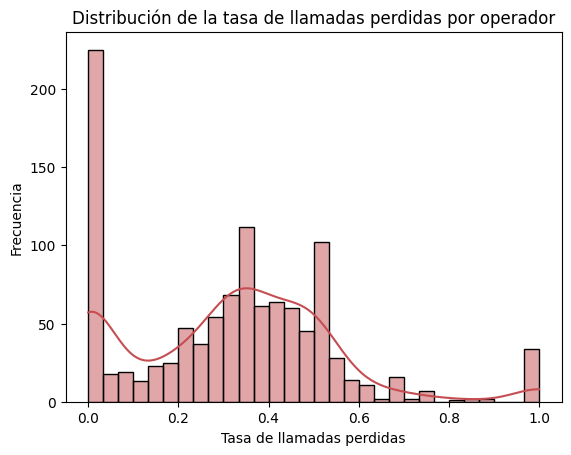

In [20]:
# Excluimos operadores sin llamadas entrantes
operator_stats = operator_stats[operator_stats['incoming_calls'] > 0].copy()

# Creamos el histograma con datos limpios
sns.histplot(operator_stats['missed_call_rate'], bins=30, kde=True, color='#C44E52')
plt.title('Distribución de la tasa de llamadas perdidas por operador')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Frecuencia')
plt.show()

Al igual que sucede con el tiempo de espera, la tasa de llamadas perdidas nos dice que la mayoría de los operadores tienen tasa bajas (de 0 a 20% como máximo). Algunos operadores tienen tasas muy altas, lo que indica que muchos operadores pierden entre 25% y 45% de las llamadas. Asimismo, hay una cola hacia valores altos (0,7 a 1) casos críticos donde se pierden casi todas las llamadas.

Sería interesante evaluar si el tiempo de epera afecta directamente el número de llamadas perdidas.

In [21]:
# Calculamos el coeficiente de correlación
correlation = operator_stats['avg_waiting_time'].corr(operator_stats['missed_call_rate'])
correlation

0.2369800397251734

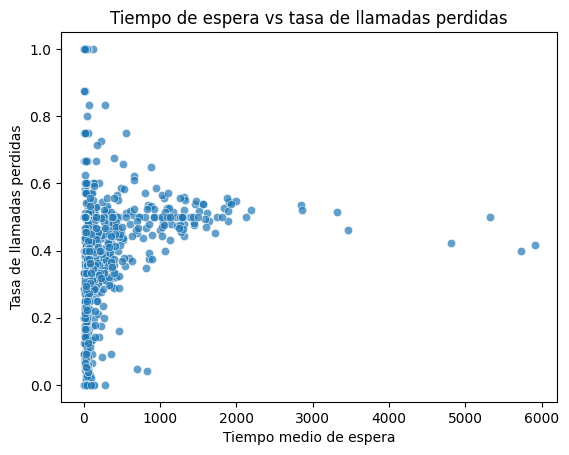

In [22]:
# Ahora queremos saber si, a mayor espera, hay más llamadas perdidas
sns.scatterplot(data=operator_stats, x='avg_waiting_time', y='missed_call_rate', alpha=0.7)
plt.title('Tiempo de espera vs tasa de llamadas perdidas')
plt.xlabel('Tiempo medio de espera')
plt.ylabel('Tasa de llamadas perdidas')
plt.show()

Podemos decir que sí hay una tendencia  a perder más llamadas por largas esperas, pero el tiempo de espera solo explica el 5% de la variación en llamadas perdidas, así que no es una correlación fuerte.

Cuando el tiempo de espera es bajo, la tasa de llamadas perdidas es muy variable (desde 0 hasta casi 1). A medida que el tiempo de espera aumenta, la tasa de llamadas perdidas tiende a concentrarse alrededor de valores altos (0,4 a 0,6). Adicionalmente, hay datos muy dispersos de operadores con tiempos de espera extremadamente altos (3000 a 6000) y tasas de llamadas perdidas altas.

Esto sugiere que la ineficiencia en estos indicadores se deba a otros factores como: la carga del operador (muchas llamadas), horarios de mayor demanda o problemas técnicos.

In [23]:
# Establecemos nuestra métrica de tasa de llamadas salientes
operator_stats['outgoing_call_rate'] = (operator_stats['outgoing_calls'] / operator_stats['total_calls'])
operator_stats[['operator_id','outgoing_call_rate']]

,operator_id,outgoing_call_rate
0,879896,0.113174
1,879898,0.031477
2,880020,0.407407
3,880022,0.347032
4,880026,0.081181
...,...,...
1087,972410,0.051948
1088,972412,0.081967
1089,972460,0.128571
1090,973120,0.666667


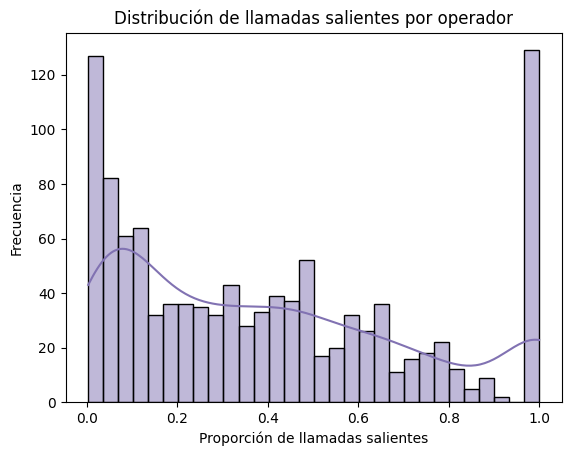

In [24]:
# Detectamos operadores con baja actividad saliente
sns.histplot(operator_stats['outgoing_call_rate'], bins=30, kde=True, color='#8172B2')
plt.title('Distribución de llamadas salientes por operador')
plt.xlabel('Proporción de llamadas salientes')
plt.ylabel('Frecuencia')
plt.show()

Viendo el histograma, nos podemos dar cuenta de que la mayoría de operadores tienen muy pocas llamadas salientes. Lo que alarga nuestra cola hacia la derecha donde el número de llamadas salientes se concentra en pocos de ellos.

El comportamiento no es homogéneo, y lo vemos porque hay operadores muy especializados (solo entrantes o solo salientes) y pocos en un punto balanceado. Esto puede indicar roles distintos, campañas específicas o mala distribución del trabajo.

Nota importante: Hasta esta parte de nuestro análisis, no se utilizó del todo el dataset telecom_clients_us.csv para realizar el análisis principal porque el objetivo del proyecto es evaluar la eficiencia de los operadores, y todas las métricas relevantes se encuentran en el dataset de llamadas. El dataset de clientes puede emplearse para análisis complementarios, pero no afecta directamente la identificación de operadores ineficaces.

### Análisis de impacto del tipo de cliente

Queremos evaluar si el tipo de cliente por plan está asociado con un mayor volumen de llamadas, una mayor tasa de llamadas perdidas y un mayor tiempo de espera.

In [25]:
# Unimos los datasets
telecom_clients = telecom.merge(clients, on='user_id', how='left')

In [26]:
# Analisamos por plan
plan_stats = telecom_clients.groupby('tariff_plan').agg(total_calls=('calls_count', 'sum'), missed_calls=('is_missed_call', 'sum'), avg_waiting_time=('waiting_time', 'mean')).reset_index()
plan_stats['missed_call_rate'] = (plan_stats['missed_calls'] / plan_stats['total_calls'])
plan_stats

,tariff_plan,total_calls,missed_calls,avg_waiting_time,missed_call_rate
0,A,420558,4748,632.493901,0.011290
1,B,152375,5445,163.146283,0.035734
2,C,200106,5325,194.592432,0.026611


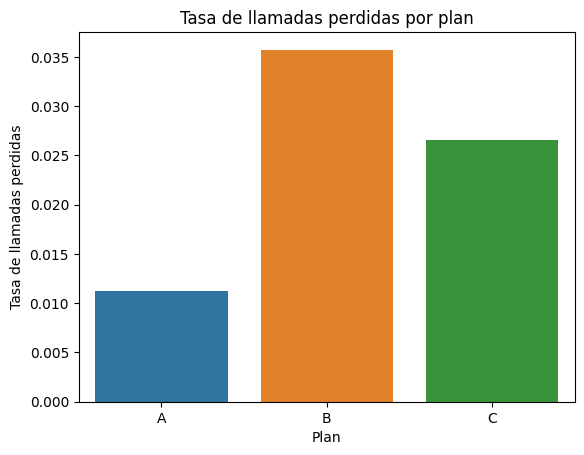

In [27]:
# Graficamos la tasa de llamadas perdidas por plan
sns.barplot(data=plan_stats, x='tariff_plan', y='missed_call_rate')
plt.title('Tasa de llamadas perdidas por plan')
plt.xlabel('Plan')
plt.ylabel('Tasa de llamadas perdidas')
plt.show()

Observando nuestro gráfico de llamadas perdidas por plan, nos damos cuenta que quien tiene la mayor tasa de llamadas perdidas es el plan B (aunque no se puede considerar alto 3,57%). En realidad, esta métrica por plan no da a entender que la tasa de llamadas perdidas no es tan alta como hubiéramos podido imaginar.

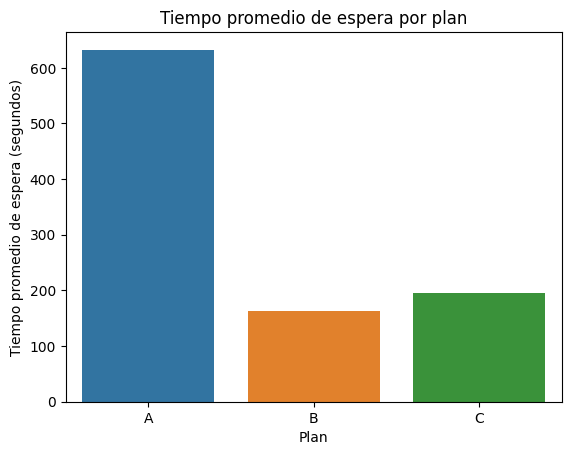

In [28]:
# Graficamos el tiempo promedio de espera por plan
sns.barplot(data=plan_stats, x='tariff_plan', y='avg_waiting_time')
plt.title('Tiempo promedio de espera por plan')
plt.xlabel('Plan')
plt.ylabel('Tiempo promedio de espera (segundos)')
plt.show()

Ahora, analizando nuestro gráfico de tiempo promedio de espera por plan, vemos que el promedio de espera es alto en el plan A (10,54 minutos aproximadamente), a diferencia de su tasa de llamadas perdidas, que es la más baja. Esto confirma el resultado del análisis de correlación general que hicimos antes.

Para los casos de los planes B y C se ven promedios de espera no tan altos (2,7 y 3,2 minutos aproximadamente).

In [29]:
# Buscamos la antiguedad de los clientes
telecom_clients['client_age_months'] = ((pd.to_datetime(telecom_clients['date']).dt.tz_localize(None) - pd.to_datetime(telecom_clients['date_start']).dt.tz_localize(None)).dt.days / 30)

# Analisamos por segmentos de antigüedad
age = telecom_clients.groupby(pd.cut(telecom_clients['client_age_months'], bins=[0, 1, 2, 3, float('inf')], labels=['Nuevo', 'Un mes', 'Dos mes', 'Antiguo'])).agg({'is_missed_call': ['count', 'sum', 'mean'], 'waiting_time': 'mean', 'call_duration': 'mean'})
age

is_missed_call                 waiting_time call_duration
                           count   sum      mean         mean          mean
client_age_months                                                          
Nuevo                      16189  5884  0.363457   403.451541   1201.866700
Un mes                     16827  5561  0.330481   308.833957    976.462828
Dos mes                     9516  2966  0.311686   218.617802    836.807797
Antiguo                     3083  1053  0.341550   150.464807    745.246189

In [30]:
corr = age[('waiting_time', 'mean')].corr(age[('call_duration', 'mean')])
corr

0.9910359887364175

El análisis por tipo de cliente muestra diferencias moderadas en la tasa de llamadas perdidas (siendo muy similar en todas). Sin embargo, en el tiempo de espera promedio según la antigüedad del cliente, vemos que es mayor para los clientes nuevos y que llevan apenas un mes.

Algo que podemo observar que la duración de las llamadas sí pueden influir en estos casos en el tiempo de espera, dependiendo del cliente, ya que tienen tiempos bastante elevados de ambas métricas para los dos tipos de clientes más nuevos. Comprobando con nuestro coeficiente de correlación: 99,1%. Esto puede sugerirnos que los clientes nuevos requieren más atención, lo que impacta directamente en la eficiencia operativa.

## 4. Identificación de operadores ineficaces

En este caso, se propone que para determinar si un operador es ineficiente, debe si cumplir al menos 2 de estas condiciones:

1. La tasa de llamadas perdidas > percentil 75
2. El tiempo medio de espera > percentil 75
3. Las llamadas salientes < percentil 25

Teniendo en cuenta esto, calculamos los percentiles de cada una de nuestras métricas.

In [31]:
# Teniendo en cuenta los percentiles propuestos, calculamos para cada uno
missed_threshold = operator_stats['missed_call_rate'].quantile(0.75)
waiting_threshold = operator_stats['avg_waiting_time'].quantile(0.75)
outgoing_threshold = operator_stats['outgoing_call_rate'].quantile(0.25)

In [32]:
# Luego, sumamos todas estas condiciones para hallar a los operadores ineficientes
operator_stats['inefficient'] = ((operator_stats['missed_call_rate'] > missed_threshold).astype(int) + (operator_stats['avg_waiting_time'] > waiting_threshold).astype(int) + (operator_stats['outgoing_call_rate'] < outgoing_threshold).astype(int)) >= 2

In [33]:
# Sacamos las estadísticas descriptivas para operadores eficientes vs ineficientes
total_operators = len(operator_stats)
inefficient_count = operator_stats['inefficient'].sum()
efficient_count = total_operators - inefficient_count

print(f"Total de operadores analizados: {total_operators}")
print(f"Operadores ineficientes: {inefficient_count} ({inefficient_count/total_operators*100:.1f}%)")
print(f"Operadores eficientes: {efficient_count} ({efficient_count/total_operators*100:.1f}%)")

Total de operadores analizados: 1092
Operadores ineficientes: 261 (23.9%)
Operadores eficientes: 831 (76.1%)


In [34]:
# Ahora comparamos las métricas, separando por grupos
inefficient_ops = operator_stats[operator_stats['inefficient']]
efficient_ops = operator_stats[~operator_stats['inefficient']]

In [35]:
# Sacamos el tiempo de espera en segundos
print(f"Operadores ineficientes - Promedio: {inefficient_ops['avg_waiting_time'].mean():.1f}")
print(f"Operadores eficientes - Promedio: {efficient_ops['avg_waiting_time'].mean():.1f}")
print(f"Diferencia: {inefficient_ops['avg_waiting_time'].mean() - efficient_ops['avg_waiting_time'].mean():.1f} segundos")

Operadores ineficientes - Promedio: 754.5
Operadores eficientes - Promedio: 46.1
Diferencia: 708.4 segundos


In [36]:
# Sacamos la tasa de llamadas perdidas
print(f"Operadores ineficientes - Promedio: {inefficient_ops['missed_call_rate'].mean():.2f}")
print(f"Operadores eficientes - Promedio: {efficient_ops['missed_call_rate'].mean():.2f}")
print(f"Diferencia: {inefficient_ops['missed_call_rate'].mean() - efficient_ops['missed_call_rate'].mean():.2f}")

Operadores ineficientes - Promedio: 0.45
Operadores eficientes - Promedio: 0.27
Diferencia: 0.17


In [37]:
# Sacamos la tasa de llamadas salientes
print(f"Operadores ineficientes - Promedio: {inefficient_ops['outgoing_call_rate'].mean():.3f}")
print(f"Operadores eficientes - Promedio: {efficient_ops['outgoing_call_rate'].mean():.3f}")

Operadores ineficientes - Promedio: 0.044
Operadores eficientes - Promedio: 0.508


Una vez obtenidos los datos para identificar  a operadores ineficientes, podemos decir que estos constituyen el 23,9% del total de operadores (261 de 1092).

El tiempo de espera varía ampliamente entre operadores eficientes e ineficientes, 708,4 segundos más (casi 12 minutos adicionales). Esto se puede deber al comportamiento que vimos en nuestro análisis de tipo de cliente, donde evidenciaba que los clientes más nuevos tenían duraciones de llamadas más prolongados, lo que aumentaba el tiempo promedio de espera.

En cuanto a la tasa de llamadas perdidas, la diferencia es también muy amplia entre operadores eficientes e ineficientes, siendo de 17 puntos porcentuales por arriba del promedio.

Finalmente, con relación a las llamadas salientes, la diferencia es dramática ya que los operadores ineficientes tienen tasas muy bajas en comparación con los eficientes (0,044 vs 0,508).

## 5. Pruebas de hipótesis estadísticas

Teniendo en cuenta las condiciones para determinar si un operador es ineficiente o no, planteamos las siguientes hipótesis:

Hipótesis 1

H₀: El tiempo de espera de operadores ineficientes es igual al de operadores eficientes

H₁: El tiempo de espera de operadores ineficientes es mayor

Para las pruebas de hipótesis se utilizó un nivel de significancia de α = 0.05, valor estándar en estudios estadísticos, lo que implica aceptar un 5 % de probabilidad de rechazar incorrectamente la hipótesis nula.

In [38]:
ineff_op = operator_stats[operator_stats['inefficient']]['avg_waiting_time']
eff_op = operator_stats[~operator_stats['inefficient']]['avg_waiting_time']

t_statistic, p_value = stats.ttest_ind(ineff_op, eff_op, equal_var=False)

print(f"Statistic t: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
print(f"Nivel de significancia (alpha): {alpha}")

if p_value < alpha:
    print('Se rechaza la hipótesis nula')
else:
    print('No se rechaza la hipótesis nula')

Statistic t: 13.8645
P-value: 0.0000
Nivel de significancia (alpha): 0.05
Se rechaza la hipótesis nula


Teniendo en cuenta que nuestro estadísitico T-test es 3,7796 con un p-value de 0,0003, podemos decir que los operadores ineficientes sí tienen tiempos de espera significativamente mayores, comprobando los análisis anteriores.

Hipótesis 2

H₀: La tasa de llamadas perdidas es igual para operadores ineficientes y eficientes

H₁: Los operadores ineficientes tienen una tasa mayor

α = 0.05

In [39]:
ineff_missed = operator_stats[operator_stats['inefficient']]['missed_call_rate']
eff_missed = operator_stats[~operator_stats['inefficient']]['missed_call_rate']

u_statistic, p_value_mw = stats.mannwhitneyu(ineff_missed, eff_missed, alternative='two-sided')

print(f"Estadístico U: {u_statistic:.4f}")
print(f"P-value: {p_value_mw:.4f}")

alpha = 0.05
print(f"Nivel de significancia (alpha): {alpha}")

if p_value_mw < alpha:
    print('Se rechaza la hipótesis nula')
else:
    print('No se rechaza la hipótesis nula')

Estadístico U: 171470.5000
P-value: 0.0000
Nivel de significancia (alpha): 0.05
Se rechaza la hipótesis nula


Teniendo en cuenta que nuestro estadísitico Mann-Whitney U es 44033 con un p-value de 0,0000, podemos decir que los operadores ineficientes sí tienen tasas de llamadas perdidas significativamente mayores, resultados que concuerdan con nuestros análisis anteriores.

## 6. Segmentación de operadores (no supervisada)

Nuestro objetivo es encontrar perfiles de operadores con comportamientos similares, usando métricas operativas, sin usarlos para decidir directamente quién es ineficiente.

Para este análisis utilizamos las variables:

* missed_call_rate → calidad
* avg_waiting_time → experiencia del cliente
* outgoing_call_rate → productividad
* total_calls → carga de trabajo

In [40]:
# Usamos las métricas relevantes y eliminamos datos nulos
features = operator_stats[['missed_call_rate', 'avg_waiting_time', 'outgoing_call_rate', 'total_calls']].dropna()

In [41]:
# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [42]:
# Entrenamos el modelo
kmeans = KMeans(n_clusters=3, random_state=42)
operator_stats['cluster'] = kmeans.fit_predict(X_scaled)

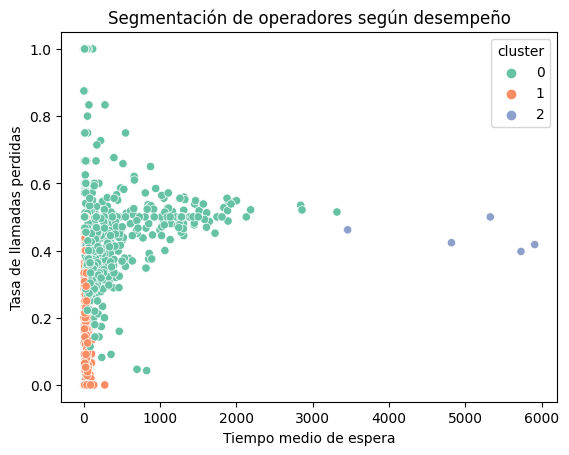

In [43]:
# Visualizamos los clústers
sns.scatterplot(data=operator_stats, x='avg_waiting_time', y='missed_call_rate', hue='cluster', palette='Set2')
plt.title('Segmentación de operadores según desempeño')
plt.xlabel('Tiempo medio de espera')
plt.ylabel('Tasa de llamadas perdidas')
plt.show()

In [44]:
# Sacamos los promedios por clúster
cluster_profile = operator_stats.groupby('cluster').agg({'total_calls': 'sum', 'missed_calls': 'mean', 'incoming_calls': 'mean', 'outgoing_calls': 'mean', 'avg_waiting_time': 'sum', 'operator_id': 'count'}).reset_index()
cluster_profile

,cluster,total_calls,missed_calls,incoming_calls,outgoing_calls,avg_waiting_time,operator_id
0,0,556988,21.735016,57.047319,57.047319,196516.285583,634
1,1,20505,3.092715,19.348786,19.348786,13518.329945,453
2,2,195546,67.400000,159.400000,159.400000,25232.622387,5


Clusters:

Cluster 0: Operadores con desempeño mixto (tiempos de espera altos, bajo número de llamadas perdidas)
Cluster 1: Operadores mayormente eficientes (promedio de tiempos de espera bajos y llamadas perdidas)
Cluster 2: Operadores de alto riesgo (tiempos de espera altos y llamadas perdidas, es decir, 100% ineficientes)

In [45]:
# Sacamos las proporciones de operadores ineficientes por cluster
pd.crosstab(operator_stats['cluster'], operator_stats['inefficient'], normalize='index')

inefficient,False,True
cluster,,
0,0.597792,0.402208
1,0.997792,0.002208
2,0.000000,1.000000


Sacando las proporciones por cluster, podemos verificar que el grupo más ineficiente es el Cluster 2. Sin embargo, no podemos escartar al Cluster 0, la proporción de ineficiencia tiende a ser un alto, lo que se consideraría un riesgo para el negocio.

## 7. Conclusiones y recomendaciones

### Principales hallazgos:

El 23.9% de los operadores son ineficientes (261 de 1,092). Existen diferencias críticas entre operadores eficientes e ineficientes:
- El tiempo de espera es de más de 708 segundos (casi 12 minutos adicionales a los eficientes).
- En la tasa de llamadas perdidas, tenemos más de 17 puntos porcentuales por encima de los eficientes.
- Las llamadas salientes también muestran una fuerte diferencia entre eficientes e ineficientes (0,044 vs 0,508).

- 69% de llamadas son salientes, pero se concentran en pocos operadores.
- La mayoría de operadores tienen muy pocas llamadas salientes (menos del 10%).
- Sugiere problemas en la distribución de carga laboral, lo que puede estar ocacionando esas represiones.

- Existe una correlación perfecta (0,991) entre tiempo de espera y duración por antigüedad de los clientes (aunque es un tiempo muy pequeño de permanencia de los clientes).
- Los clientes nuevos requieren 10,5 minutos contra 2,5 minutos de clientes antiguos. Los operadores ineficientes pueden estar atendiendo más clientes complejos.

### Recomendaciones para el negocio:


- Se puede implementar un sistema de balanceador de carga con el objetivo de distribuir llamadas salientes más equitativamente.
- Se puede implementar, también, un sistema de cola inteligente que distribuya llamadas salientes.
- Se puede realizar un plan de capacitación al 23.9% de operadores ineficientes en manejo de llamadas salientes.
- Se puede establecer cuotas mínimas de llamadas salientes por operador para reducir el número de llamadas perdidas.

Se propone hacer un plan de mejoramiento de la siguiente manera:

Cluster 2 (5 operadores) es necesario hacer una intervención inmediata, puede ser con un plan de capacitación orientado a mejorar los tiempos de atención y a mejorar las tasas de llamadas salientes.
Cluster 0 (634 operadores) se puede hacer un programa de mejora para disminuirlos tiempos altos de espera.
Cluster 1 (453 operadores) al ser el grupo de referencia, se puede hacer un programa de mentoría donde estos operadores participen en los programas de capacitación y apoyo a los otros dos grupos.

Se puede dividir los equipos en dos grupos que se enfoquen en los tipos de clientes (nuevos y antiguos), dependiendo de la expriencia:
- Operadores junior orientados a atender los clientes antiguos con llamadas más cortas y eficientes.
- Operadores senior (con mayor experiencia) orientados a atender clientes nuevos que requieran más atención.
Es importante enfocar el entrenamiento específico para manejo de clientes por antigüedad.


- Implementar un sistema de alertas automáticas cuando tiempo de espera sea mayor a 5 minutos.
- Implementar metodologías de escalamiento de llamadas complejas a esos operadores más experimentados.
- Implementar un modelo predictivo para asignar llamadas según perfil de cliente.
- Implementar un sistema de recomendaciones para operadores.
- Realizar un análisis de patrones temporales para optimizar horarios, de acuerdo con horas pico y semanas pico.